#HW #3

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images. It did ... OK. There is significant overfitting of this model. There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture. Change one or more of the following:

The number of convolutions between downsampling
The number of filters in each layer
The initial "patchify" layer
Another hyper-parameter of your choosing
And compare your final validation accuracy to the accuracy shown here. Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train. You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Train Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 0: training loss: 0.942, accuracy: 0.671


Validate Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.000, accuracy: 0.647


Train Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: validation loss: 0.807, accuracy: 0.715


Train Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.711, accuracy: 0.756


Train Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.706, accuracy: 0.768


Train Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.729, accuracy: 0.764


Train Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: training loss: 0.192, accuracy: 0.938


Validate Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.748, accuracy: 0.780


Train Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.778, accuracy: 0.781


Train Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.819, accuracy: 0.780


Train Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.927, accuracy: 0.772


Train Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.997, accuracy: 0.777


Train Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: training loss: 0.063, accuracy: 0.980


Validate Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.056, accuracy: 0.773


Train Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.062, accuracy: 0.771


Train Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.137, accuracy: 0.774


Train Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.170, accuracy: 0.775


Train Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.179, accuracy: 0.770


Train Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15: training loss: 0.035, accuracy: 0.988


Validate Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.325, accuracy: 0.769


Train Epoch 16:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.272, accuracy: 0.774


Train Epoch 17:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.395, accuracy: 0.770


Train Epoch 18:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.371, accuracy: 0.772


Train Epoch 19:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.396, accuracy: 0.777


Train Epoch 20:   0%|          | 0/782 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20: training loss: 0.027, accuracy: 0.991


Validate Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.470, accuracy: 0.768


Train Epoch 21:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.424, accuracy: 0.772


Train Epoch 22:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.525, accuracy: 0.770


Train Epoch 23:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.474, accuracy: 0.774


Train Epoch 24:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.601, accuracy: 0.765


Train Epoch 25:   0%|          | 0/782 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 25: training loss: 0.023, accuracy: 0.992


Validate Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.525, accuracy: 0.770


Train Epoch 26:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.536, accuracy: 0.769


Train Epoch 27:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.575, accuracy: 0.772


Train Epoch 28:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.580, accuracy: 0.774


Train Epoch 29:   0%|          | 0/782 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.722, accuracy: 0.769


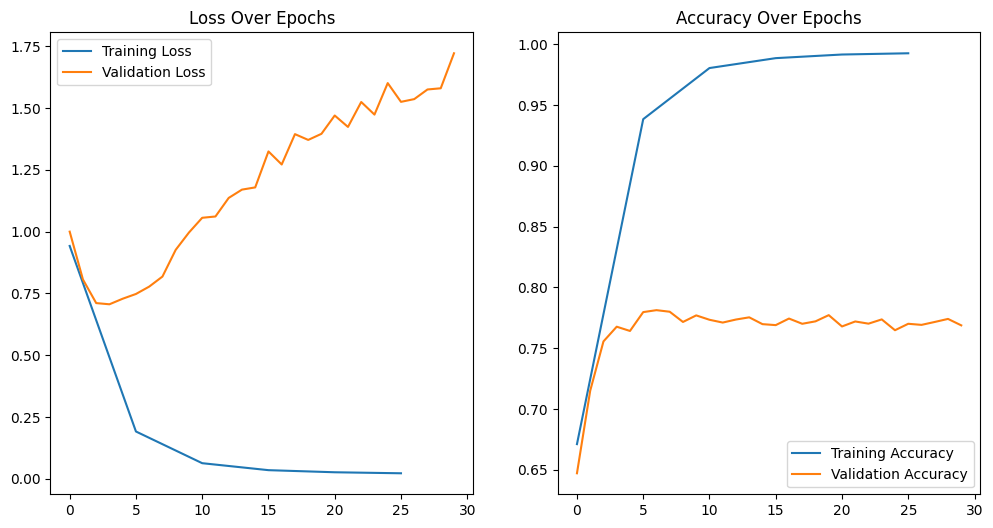

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

# Modified CNN Model
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjust input dimensions based on CIFAR-10 image size
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.fc2(x)
        return x

model = ModifiedCNN()

# Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Functions
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch in dataloader:
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        progress_bar.update(1)

def evaluate(dataloader, model, loss_fn, progress_bar):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            progress_bar.update(1)
    return correct / len(dataloader.dataset), total_loss / len(dataloader)

# Training Loop
epochs = 30
training_losses, validation_losses = [], []
training_accuracies, validation_accuracies = [], []

for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            training_losses.append(loss)
            training_accuracies.append(acc)

    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        validation_losses.append(loss_val)
        validation_accuracies.append(acc_val)

# Plotting Results
import matplotlib.pyplot as plt

epochs_range = range(epochs)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[::5], training_losses, label="Training Loss")
plt.plot(epochs_range, validation_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range[::5], training_accuracies, label="Training Accuracy")
plt.plot(epochs_range, validation_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()
